## 0. Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/EIANN

/content/drive/MyDrive/EIANN


In [3]:
import torch
import torchvision
import torchvision.transforms as T
from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as pt

pt.update_plot_defaults()

In [4]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [5]:
# Load dataset
tensor_flatten = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])
MNIST_train_dataset = torchvision.datasets.MNIST(root='/datasets/MNIST_data/', train=True, download=True,
                                         transform=tensor_flatten)
MNIST_test_dataset = torchvision.datasets.MNIST(root='/datasets/MNIST_data/',
                                        train=False, download=True,
                                        transform=tensor_flatten)

# Add index to train & test data
MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train_dataset):
    target = torch.eye(len(MNIST_train_dataset.classes))[target]
    MNIST_train.append((idx, data, target))
    
MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test_dataset):
    target = torch.eye(len(MNIST_test_dataset.classes))[target]
    MNIST_test.append((idx, data, target))
    
# Put data in dataloader
data_generator = torch.Generator()
train_dataloader = torch.utils.data.DataLoader(MNIST_train, shuffle=True, generator=data_generator)
train_sub_dataloader = torch.utils.data.DataLoader(MNIST_train[0:5000], shuffle=True, generator=data_generator)
test_dataloader = torch.utils.data.DataLoader(MNIST_test, batch_size=10000, shuffle=False)

epochs = 1
data_seed = 0
network_seed = 42

### Backprop (no weight contraints)

In [9]:
# Create network
network_config = ut.read_from_yaml('EIANN/config/MNIST/EIANN_1_hidden_mnist_backprop_relu_SGD_config.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bp_network = Network(layer_config, projection_config, seed=network_seed, device=device, **training_kwargs)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Batch accuracy = 87.66000366210938%


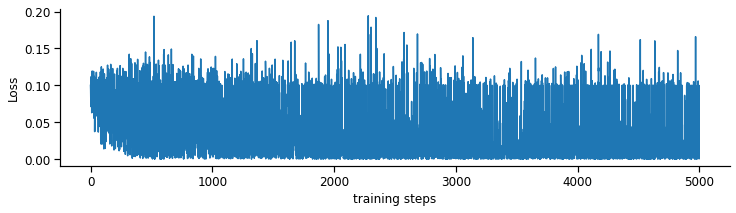

In [10]:
# Train network
data_generator.manual_seed(data_seed)
bp_network.train(train_sub_dataloader,
              epochs=epochs, 
              store_history=False,
              store_weights=False,
              status_bar=True)

ut.compute_batch_accuracy(bp_network, test_dataloader)
pt.plot_train_loss_history(bp_network)
# pt.plot_test_loss_history(bp_network, test_dataloader, stepsize=50)
# pt.plot_MNIST_examples(bp_network, test_dataloader)

### Backprop (Dale's Law)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Batch accuracy = 73.69000244140625%


  0%|          | 0/101 [00:00<?, ?it/s]

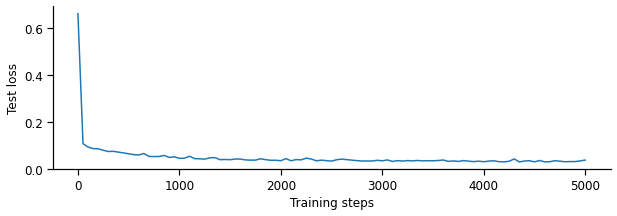

In [6]:
# Create network
network_config = ut.read_from_yaml('EIANN/config/MNIST/EIANN_1_hidden_mnist_backprop_Dale_relu_SGD_config.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bpDale_network = Network(layer_config, projection_config, seed=network_seed, device=device, **training_kwargs)


# Train network
data_generator.manual_seed(data_seed)
bpDale_network.train(train_sub_dataloader, 
              epochs=epochs, 
              store_history=True,
              store_weights=True,
              status_bar=True)

ut.compute_batch_accuracy(bpDale_network, test_dataloader)
# pt.plot_train_loss_history(bpDale_network)
pt.plot_test_loss_history(bpDale_network, test_dataloader, stepsize=50)
# pt.plot_MNIST_examples(bpDale_network, test_dataloader)

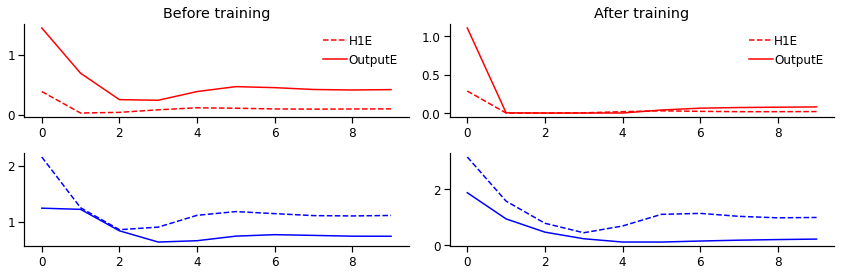

In [11]:
from EIANN.plot import *

fig,ax = plt.subplots(2,2,figsize=(12,4))

t = 0
hidden_activity = torch.mean(bpDale_network.H1.E.activity_history[t], dim=1)
output_activity = torch.mean(bpDale_network.Output.E.activity_history[t], dim=1)
ax[0,0].plot(hidden_activity.cpu(),'--',color='r', label='H1E')
ax[0,0].plot(output_activity.cpu(),color='r', label='OutputE')
ax[0,0].set_title('Before training')
ax[0,0].legend()

hiddenFBI_activity = torch.mean(bpDale_network.H1.FBI.activity_history[t], dim=1)
outputFBI_activity = torch.mean(bpDale_network.Output.FBI.activity_history[t], dim=1)
ax[1,0].plot(hiddenFBI_activity.cpu(),'--',color='b', label='H1FBI')
ax[1,0].plot(outputFBI_activity.cpu(),color='b', label='OutputFBI')


t = -1
hidden_activity = torch.mean(bpDale_network.H1.E.activity_history[t], dim=1)
output_activity = torch.mean(bpDale_network.Output.E.activity_history[t], dim=1)
ax[0,1].plot(hidden_activity.cpu(),'--',color='r', label='H1E')
ax[0,1].plot(output_activity.cpu(),color='r', label='OutputE')
ax[0,1].set_title('After training')
ax[0,1].legend()

hiddenFBI_activity = torch.mean(bpDale_network.H1.FBI.activity_history[t], dim=1)
outputFBI_activity = torch.mean(bpDale_network.Output.FBI.activity_history[t], dim=1)
ax[1,1].plot(hiddenFBI_activity.cpu(),'--',color='b', label='H1FBI')
ax[1,1].plot(outputFBI_activity.cpu(),color='b', label='OutputFBI')

plt.tight_layout()
plt.show()

## BTSP

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Batch accuracy = 9.800000190734863%


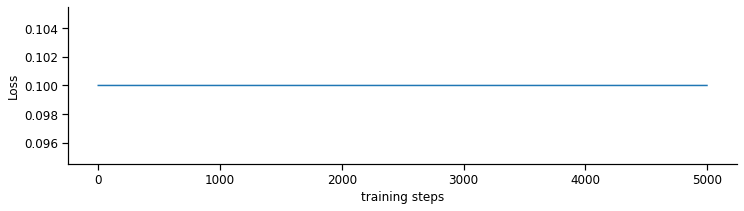

In [6]:
# Create network
network_config = ut.read_from_yaml('EIANN/config/MNIST/EIANN_1_hidden_mnist_BTSP_config.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

btsp_network = Network(layer_config, projection_config, seed=network_seed, device=device, **training_kwargs)


# Train network
data_generator.manual_seed(data_seed)
btsp_network.train(train_sub_dataloader, 
                   epochs=epochs, 
                   store_history=False, 
                   store_weights=True, 
                   status_bar=True)

ut.compute_batch_accuracy(btsp_network, test_dataloader)
pt.plot_train_loss_history(btsp_network)
# pt.plot_test_loss_history(btsp_network, test_dataloader, stepsize=100)
# pt.plot_MNIST_examples(btsp_network, test_dataloader)